In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Load data

In [2]:
spd_data = np.load("cleandata.npy", allow_pickle=True)
spd_data.shape

(471, 1494)

PCA

In [3]:
n_components = 8
pca = PCA(n_components=n_components)

# 对SPD数据进行PCA分析，得到得分矩阵
scores = pca.fit_transform(spd_data)  # 1494x8的矩阵

scores.shape

(471, 8)

M

In [5]:
# 构建高斯滤波器集合
mu = np.array([415, 445, 480, 515, 555, 590, 630, 680])
sigma = np.array([11.0403, 12.7388, 15.2866, 16.5605, 16.5605, 16.9851, 21.2314, 22.0807])
wavelengths = np.arange(360, 831)
filters = np.zeros((8, len(wavelengths)))
for i in range(8):
    filters[i] = np.exp(-0.5 * ((wavelengths - mu[i]) / sigma[i])**2)

# 将得分矩阵与高斯滤波器集合相乘，得到M矩阵
M = np.dot(filters, scores)  # (8,471)的矩阵乘以(471,8)的矩阵得到8x8的矩阵


r

In [6]:
# 计算响应矩阵
response_matrix = np.dot(filters, spd_data)

# 计算响应矩阵的平均值
mean_response = np.mean(response_matrix, axis=1)
mean_response = mean_response.reshape(-1, 1) # 将平均响应向量变成一个列向量

print(mean_response)
print(mean_response.shape) #(8,1)


[[0.036534920539607614]
 [0.29821023297154964]
 [0.2535773618779846]
 [0.37819348604623915]
 [0.596526046603663]
 [0.7175100071781976]
 [0.7856590049375198]
 [0.38293180734937315]]
(8, 1)


M_inv


In [7]:
M_inv= np.linalg.inv(M)
M_inv.shape #(8,8)

(8, 8)

A

In [8]:
response_diff = response_matrix - mean_response
print(response_diff.shape)

a_hat = np.dot(M_inv, response_diff)
print(a_hat.shape)

(8, 1494)
(8, 1494)


Evaluation

In [9]:
def compute_MAE(s, s_re):
    return np.mean(np.absolute(s - s_re))

def compute_RMSE(s, s_re):
    return np.sqrt(np.mean(np.square(s- s_re)))

def compute_RRMSE(s, s_re):
    return compute_RMSE(s, s_re) / np.mean(s_re)

def compute_GFC(s, s_hat):
    num = abs(np.sum(s * s_hat))
    denom_s = np.sqrt(np.sum(s ** 2) + 1e-9)
    denom_s_hat = np.sqrt(np.sum(s_hat ** 2) + 1e-9)
    return num / (denom_s * denom_s_hat)


重建光谱

总体

In [10]:
mean_spd = np.mean(spd_data, axis=1) #(471,1)
reconstructed_spectrum = np.dot(scores, a_hat) + mean_spd[:, np.newaxis]
reconstructed_spectrum.shape

(471, 1494)

画图

In [11]:
def spectrum_plot(wavelengths, True_Spectrum, Reconstructed_Spectrum ):
    # 创建一个包含三个子图的图像
    fig, axs = plt.subplots(3, 1)

# 绘制真实光谱图
    axs[0].plot(wavelengths, True_Spectrum, label='True Spectrum')
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel('Intensity')
    axs[0].set_title('True Spectrum vs Reconstructed Spectrum')
    axs[0].legend()

# 绘制重建光谱图
    axs[1].plot(wavelengths, Reconstructed_Spectrum, label='Reconstructed Spectrum')
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Intensity')
    axs[1].legend()

# 绘制重建光谱和真实光谱叠加的图
    axs[2].plot(wavelengths, True_Spectrum, label='True Spectrum')
    axs[2].plot(wavelengths, Reconstructed_Spectrum, label='Reconstructed Spectrum')
    axs[2].set_xlabel('Wavelength (nm)')
    axs[2].set_ylabel('Intensity')
    axs[2].legend()

    plt.tight_layout()
    plt.show()


FOr s2

spd_data

In [12]:
MAE2 = compute_MAE(spd_data[:,100], reconstructed_spectrum[:,1])
RMSE2 = compute_RMSE(spd_data[:,1], reconstructed_spectrum[:,1])
RRMSE2 = compute_RRMSE(spd_data[:,1], reconstructed_spectrum[:,1])
GFC2 = compute_GFC(spd_data[:,1], reconstructed_spectrum[:,1])

print("MAE: ", MAE2)
print("RMSE: ", RMSE2)
print("RRMES: ", RRMSE2)
print("GFC: ", GFC2)

MAE:  0.0037693755520442737
RMSE:  0.0022037283727439445
RRMES:  0.32172668118099396
GFC:  0.9843262651974012


In [13]:
MAE2 = compute_MAE(spd_data[:,100], reconstructed_spectrum[:,100])
RMSE2 = compute_RMSE(spd_data[:,100], reconstructed_spectrum[:,100])
RRMSE2 = compute_RRMSE(spd_data[:,100], reconstructed_spectrum[:,100])
GFC2 = compute_GFC(spd_data[:,100], reconstructed_spectrum[:,100])

print("MAE: ", MAE2)
print("RMSE: ", RMSE2)
print("RRMES: ", RRMSE2)
print("GFC: ", GFC2)

MAE:  0.0007752040646290683
RMSE:  0.0009968797783384696
RRMES:  0.14553645838935056
GFC:  0.9951940394788995


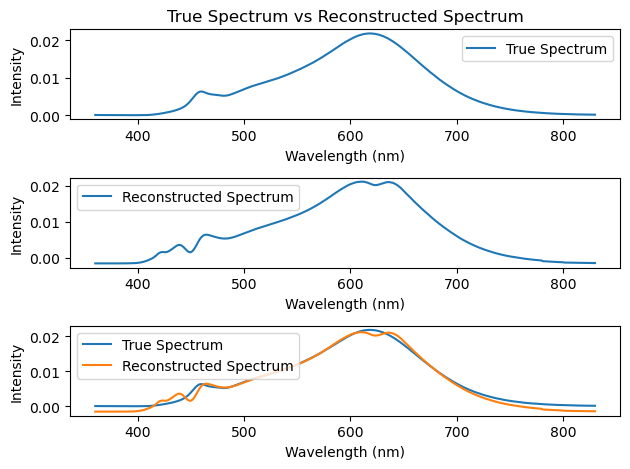

In [14]:
spectrum_plot(wavelengths, spd_data[:,100], reconstructed_spectrum[:,100])